In [3]:
import torch
import matplotlib.pyplot as plt

import invgrad
from models.resnet import ResNet50
from utils import datasets

In [4]:
num_images = 1

In [19]:
setup = invgrad.utils.system_startup()
defs = invgrad.training_strategy('conservative')

loss_fn, trainloader, validloader =  invgrad.construct_dataloaders('CIFAR10', defs)

checkpoint = torch.load("/kaggle/input/fedavg-100pt/fedavg_100.pt")  # not available on github due to size restrictions
model = ResNet50().to(**setup)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

Currently evaluating -------------------------------:
Tuesday, 17. May 2022 04:55PM
CPUs: 1, GPUs: 1 on d8ead4517a2d.
GPU : Tesla T4
Files already downloaded and verified
Files already downloaded and verified


In [20]:
dm = torch.as_tensor(datasets.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(datasets.cifar10_std, **setup)[:, None, None]

def plot(tensor, filename=None):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        plt.imshow(tensor[0].permute(1, 2, 0).cpu())
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu())

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

In [22]:
ground_truth, labels = [], []
idx = 0  # ?
while len(labels) < num_images:
    img, label = validloader.dataset[idx]
    idx += 1
    if label not in labels:
        labels.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth.append(img.to(**setup))
ground_truth = torch.stack(ground_truth)
labels = torch.cat(labels)

['automobile']


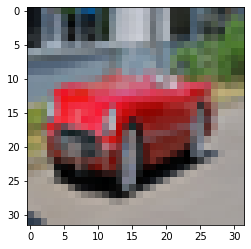

In [23]:
plot(ground_truth)
print([validloader.dataset.classes[l] for l in labels])

In [24]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [25]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_parameters = invgrad.reconstruction_algorithms.loss_steps(model, ground_truth, labels, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters = [p.detach() for p in input_parameters]

It: 0. Rec. loss: 0.0213.
It: 500. Rec. loss: 0.0056.
It: 1000. Rec. loss: 0.0055.
It: 1500. Rec. loss: 0.0054.
It: 2000. Rec. loss: 0.0055.
Recovery interrupted manually in iteration 2151!
Choosing optimal result ...
Optimal result score: 0.0054
Total time: 929.7540602684021.


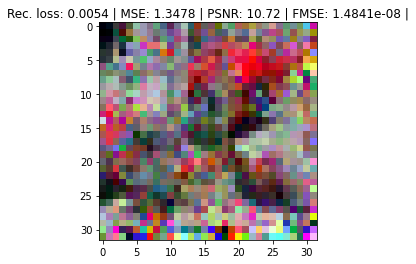

In [28]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=8_000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = invgrad.FedAvgReconstructor(model, (dm, ds), local_steps, local_lr, config,
                                             use_updates=use_updates)
output, _ = rec_machine.reconstruct(input_parameters, labels, img_shape=(3, 32, 32))

plot(output)